#### Grey Wolf Optimization

The first step to define an optimizer is to define the domain on which the solution is searched. 

Second step is to define what we call error from optimum value or the loss function or the fitness function based on which solutions are judged. 

Third step is to generate random solutions from the domain and judge them based on loss function. 

Next, we update these solutions or solution based on an update expression which is expected to minimize the loss function further. 

In the present code, the loss function/error defined will be mostly based on the previous code for TDOA. We'll just have to make the form amenable to the algorithm we want to run. 

For the present solution we would generate some synthetic time of arrivals beforehand and then using that data we'll process it further. The identified domain is a rectangular domain of size 1km * 1km.


In [1]:
# importing required libraries 

import numpy as np
import matplotlib.pyplot as plt

In [2]:
# defining a suitable fitness function
n_rec = 51 # number of receivers
def fitness_GWO(pos_matrix,ToA,wave_vel):
    '''The function returns the error value for a given position matrix(pos_matrix) consisting of source location as the first element
    and the receiver positions as all the rest elements. ToA is a vector of the time of arrival of seismic waves for receivers
    Wave_vel is the velocity of waves'''
    
    n_rec = np.shape(ToA)[0]
    TDoA = np.zeros(shape= (n_rec-1)) # created a new variable which will store time difference wrt the first receiver
    TDoA[:] = (ToA[1:] - ToA[0]).reshape(n_rec-1)
    # Now getting the value for time of arrival from the position of source and receivers
    ToA_pos = np.zeros_like(ToA)
    pos_diff = np.zeros(shape = (np.shape(pos_matrix)[0],np.shape(pos_matrix)[1]-1))  # vector denoting the position of receivers wrt source
    pos_diff = pos_matrix[1:] - pos_matrix[0]
    ToA_pos[:] = (np.sqrt(pos_diff[:,0]**2 + pos_diff[:,1]**2)).reshape(n_rec,1)/wave_vel
    TDoA_pos = np.zeros_like(TDoA)
    TDoA_pos[:] = (ToA_pos[1:] - ToA_pos[0]).reshape(n_rec-1)
    error_vector = TDoA_pos - TDoA
    error = np.dot(error_vector.T,error_vector)
    
    return error

In [3]:
# Now generating the synthetic data for testing
wave_vel = 1 # m/s

rec_pos_actual =300 + np.random.normal(loc=0.0,scale =50,size = (n_rec,2))  # actual position for 2 receivers
src_pos_actual = np.array([0,0])
t_rec_ideal = np.zeros(shape =(n_rec,1))
# calculating the ideal time of arrival
t_rec_ideal[0:n_rec] = np.sqrt((rec_pos_actual[0:n_rec,1]-src_pos_actual[1])**2 + (rec_pos_actual[0:n_rec,0]-src_pos_actual[0])**2).reshape(n_rec,1)
#introducing noise to account for error in onset detection and sensor
noise_t = np.random.normal(loc=0.0,scale =0.2,size = (n_rec,1))
t_Rec_real = np.array(t_rec_ideal + noise_t)

In [4]:
# Now generating some random solutions for input and intializing number of wolves and their types, alpha, beta and delta are taken to be one each 

n_wolves = 15 # number of wolves 
initial_pos = 300  + np.random.normal(loc=0.0,scale =50,size = (n_wolves,n_rec+1,2))  # in order to make sure that the spread is in entire domain


In [5]:
# giving some initial values to alpha, beta and delta wolves

alpha_pos =300 + np.random.normal(loc=0.0,scale =50,size = (n_rec+1,2))
alpha_fitness = fitness_GWO(alpha_pos,t_Rec_real,wave_vel = wave_vel)
beta_pos = 300  + np.random.normal(loc=0.0,scale =50,size = (n_rec+1,2))
beta_fitness = fitness_GWO(alpha_pos,t_Rec_real,wave_vel = wave_vel)
delta_pos = 300  + np.random.normal(loc=0.0,scale =50,size = (n_rec+1,2))
delta_fitness = fitness_GWO(alpha_pos,t_Rec_real,wave_vel = wave_vel)

In [6]:
n_iter = 10000 # number of iterations
wolves_pos = np.copy(initial_pos)# creating a single vector for positions as update expression will be similar

In [7]:
# After this initial assigning of hierarchy, let's create the update expression
# Note: The first assigned hierarchy is just to ensure that the variables are not blank. This might be removed in revision

a = 2  
fitness_value = np.zeros(shape= n_wolves) # creating an array for storing fitness value for each wolf
error_iter = np.zeros(n_iter)   # creating an array for storing the minimum error for each iteration

for i in range(n_iter):
    for j in range(n_wolves):
        fitness_value[j] = fitness_GWO(wolves_pos[j],t_Rec_real,wave_vel = wave_vel)
        if fitness_value[j] <= alpha_fitness:
            delta_fitness = beta_fitness
            delta_pos = np.copy(beta_pos)
            beta_fitness = alpha_fitness
            beta_pos = np.copy(alpha_pos)
            alpha_fitness = fitness_value[j]
            alpha_pos = np.copy(wolves_pos[j])
            
        elif fitness_value[j] <= beta_fitness and fitness_value[j] >= alpha_fitness:
            delta_fitness = beta_fitness
            delta_pos = np.copy(beta_pos)
            beta_fitness = fitness_value[j]
            beta_pos = np.copy(wolves_pos[j])
            
        elif fitness_value[j] <= delta_fitness and fitness_value[j] >= beta_fitness:
            delta_fitness = fitness_value[j]
            delta_pos = np.copy(wolves_pos[j])
    
    #Now that hierarchy is assigned let's update the positions
    
    a= a - 2/n_iter
    
    for j in range(n_wolves):
        r1 = np.random.random(size=(np.shape(alpha_pos)))
        r2 = np.random.random(size=(np.shape(alpha_pos)))
        A1 = 2*a*r1 - a
        C1 =2*r2
    
        D_alpha = abs(C1 * alpha_pos - wolves_pos[j])  # distance from the alpha wolf
        X1 = alpha_pos - A1 * D_alpha

        r1 = np.random.random(size=(np.shape(alpha_pos)))
        r2 = np.random.random(size=(np.shape(alpha_pos)))
        A2 = 2*a*r1 - a
        C2 =2*r2
    
        D_beta =abs(C2 * beta_pos - wolves_pos[j])
        # Equation (3.5)-part 2
        X2 = beta_pos - A2 * D_beta
    
        r1 = np.random.random(size=(np.shape(alpha_pos)))
        r2 = np.random.random(size=(np.shape(alpha_pos)))
        A3 = 2*a*r1 - a
        C3 =2*r2
        D_delta = abs(C3 * delta_pos- wolves_pos[j])
        X3 = delta_pos - A3*D_delta
        
        wolves_pos[j] = (X1+X2+X3)/3
    
    error_iter[i] = alpha_fitness
    
    
    
            
        

The guessed source position is the first position that we have guessed and we start our analysis with. The estimated source position is the source position received as output of GWO. Actual source position is as the name implies actual position of the soure.

Text(0, 0.5, 'Y(m)')

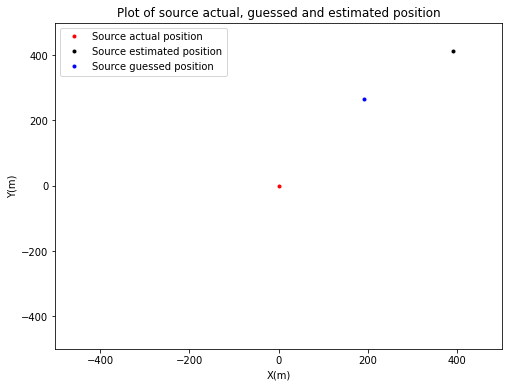

In [8]:
# Examining the results via plot
plt.figure(figsize=(8,6))
#plt.plot(rec_pos_actual[:,0],rec_pos_actual[:,1],'b.',label='Receivers actual position')
plt.plot(src_pos_actual[0],src_pos_actual[1],'r.',label='Source actual position')
#plt.plot(alpha_pos[1:,0],alpha_pos[1:,1],'g.',label='Receivers estimated position')
plt.plot(alpha_pos[0,0],alpha_pos[0,1],'k.',label='Source estimated position')
plt.plot(initial_pos[0,0,0],initial_pos[0,0,1],'b.',label='Source guessed position')
plt.legend()
plt.title('Plot of source actual, guessed and estimated position')
plt.xlim(-500,500)
plt.ylim(-500,500)
plt.xlabel('X(m)')
plt.ylabel('Y(m)')

Text(0, 0.5, 'Y(m)')

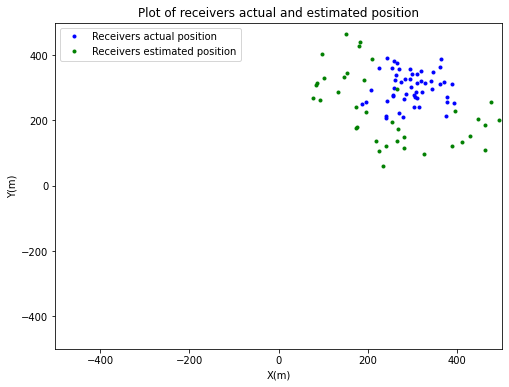

In [9]:
plt.figure(figsize=(8,6))
plt.plot(rec_pos_actual[:,0],rec_pos_actual[:,1],'b.',label='Receivers actual position')
#plt.plot(initial_pos[0,1:,0],initial_pos[0,1:,1],'k.',label='REceivers guessed position')
plt.plot(alpha_pos[1:,0],alpha_pos[1:,1],'g.',label='Receivers estimated position')


plt.legend()
plt.title('Plot of receivers actual and estimated position')
plt.xlim(-500,500)
plt.ylim(-500,500)
plt.xlabel('X(m)')
plt.ylabel('Y(m)')

Now we need to analyse the iterations vs misfit or the error plot and look how fast does the algorithm converge.


Text(0, 0.5, 'Error (m^2)')

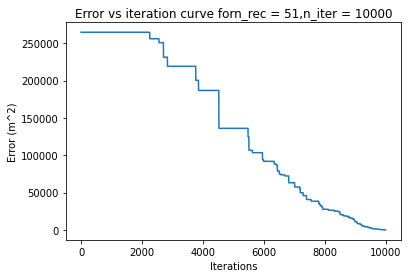

In [10]:
plt.plot(np.arange(start= 0,stop = n_iter,step =1), error_iter)
plt.title('Error vs iteration curve for'+'n_rec = '+str(n_rec)+',n_iter = '+ str(n_iter))
plt.xlabel('Iterations')
plt.ylabel('Error (m^2)')

An interesting thing to note here is that while the error goes to zero, the the location of source and the reeivers is not exactly same as required.

For now, modifying the code for restricting the domain of serach for both source and receiver. Since, the initial conditions are already tuned with known information, we need to make surce that the update expression doesn't cross certain bounds. These bounds can be enforced by either subtracting/adding some number. Or using modulo or the one which we are going to try now, reject all movements outside the designated region.


In [11]:
# After this initial assigning of hierarchy, let's create the update expression
# Note: The first assigned hierarchy is just to ensure that the variables are not blank. This might be removed in revision
# calculating the min and max time of arrival
TOA_min = np.min(t_Rec_real)
TOA_max = np.max(t_Rec_real)
TOA_avg = np.mean(t_Rec_real)
wolves_pos = np.copy(initial_pos)

alpha_pos =300 + np.random.normal(loc=0.0,scale =50,size = (n_rec+1,2))
alpha_fitness = fitness_GWO(alpha_pos,t_Rec_real,wave_vel = wave_vel)
beta_pos = 300  + np.random.normal(loc=0.0,scale =50,size = (n_rec+1,2))
beta_fitness = fitness_GWO(alpha_pos,t_Rec_real,wave_vel = wave_vel)
delta_pos = 300  + np.random.normal(loc=0.0,scale =50,size = (n_rec+1,2))
delta_fitness = fitness_GWO(alpha_pos,t_Rec_real,wave_vel = wave_vel)

# Source will lie within the annulus with inner radii TOA_min*wave_vel and outer radii TOA_max*wave_vel
# centered at the mean point of receivers/position of deployer
n_iter =10000
a = 2  
fitness_value = np.zeros(shape= n_wolves) # creating an array for storing fitness value for each wolf
error_iter = np.zeros(n_iter)   # creating an array for storing the minimum error for each iteration
#let's make a copy of wolves position at beginning of each iteration


for i in range(n_iter):
    for j in range(n_wolves):
        fitness_value[j] = fitness_GWO(wolves_pos[j],t_Rec_real,wave_vel = wave_vel)
        wolves_pos_copy = np.copy(wolves_pos)
        if fitness_value[j] <= alpha_fitness:
            delta_fitness = beta_fitness
            delta_pos = np.copy(beta_pos)
            beta_fitness = alpha_fitness
            beta_pos = np.copy(alpha_pos)
            alpha_fitness = fitness_value[j]
            alpha_pos = np.copy(wolves_pos[j])
            
        elif fitness_value[j] <= beta_fitness and fitness_value[j] >= alpha_fitness:
            delta_fitness = beta_fitness
            delta_pos = np.copy(beta_pos)
            beta_fitness = fitness_value[j]
            beta_pos = np.copy(wolves_pos[j])
            
        elif fitness_value[j] <= delta_fitness and fitness_value[j] >= beta_fitness:
            delta_fitness = fitness_value[j]
            delta_pos = np.copy(wolves_pos[j])
    
    #Now that hierarchy is assigned let's update the positions
    
    a= a - 2/n_iter
    
    for j in range(n_wolves):
        r1 = np.random.random(size=(np.shape(alpha_pos)))
        r2 = np.random.random(size=(np.shape(alpha_pos)))
        A1 = 2*a*r1 - a
        C1 =2*r2
    
        D_alpha = abs(C1 * alpha_pos - wolves_pos[j])  # distance from the alpha wolf
        X1 = alpha_pos - A1 * D_alpha

        r1 = np.random.random(size=(np.shape(alpha_pos)))
        r2 = np.random.random(size=(np.shape(alpha_pos)))
        A2 = 2*a*r1 - a
        C2 =2*r2
    
        D_beta =abs(C2 * beta_pos - wolves_pos[j])
        # Equation (3.5)-part 2
        X2 = beta_pos - A2 * D_beta
    
        r1 = np.random.random(size=(np.shape(alpha_pos)))
        r2 = np.random.random(size=(np.shape(alpha_pos)))
        A3 = 2*a*r1 - a
        C3 =2*r2
        D_delta = abs(C3 * delta_pos- wolves_pos[j])
        X3 = delta_pos - A3*D_delta
        
        wolves_pos[j] = (X1+X2+X3)/3
        
        # restricting the source position by a circle with centre at (300,300)
        if np.sqrt((wolves_pos[j,0,0]-300)**2 + (wolves_pos[j,0,1]-300)**2) > TOA_min*wave_vel or np.sqrt((wolves_pos[j,0,0]-300)**2 + (wolves_pos[j,0,1]-300)**2) < TOA_max*wave_vel:
            wolves_pos[j,0,:] = wolves_pos[j,0,:]
        else:
            wolves_pos[j,0,:] = np.array([300-TOA_avg*wave_vel,300-TOA_avg*wave_vel])[:]   # assign the position on avg line if outside
        # restricting the movement of receivers to a radius of 200 m 
        for k in range(n_rec):
            if np.sqrt((wolves_pos[j,1+k,0]-300)**2 + (wolves_pos[j,1+k,1]-300)**2) > 100:
                wolves_pos[j,1+k,:] = wolves_pos_copy[j,1+k,:]  
    
    error_iter[i] = alpha_fitness
    
    
    
            
        

Text(0, 0.5, 'Y(m)')

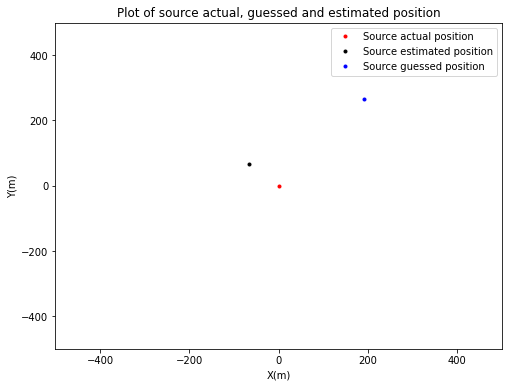

In [12]:
# Examining the results via plot
plt.figure(figsize=(8,6))
#plt.plot(rec_pos_actual[:,0],rec_pos_actual[:,1],'b.',label='Receivers actual position')
plt.plot(src_pos_actual[0],src_pos_actual[1],'r.',label='Source actual position')
#plt.plot(alpha_pos[1:,0],alpha_pos[1:,1],'g.',label='Receivers estimated position')
plt.plot(alpha_pos[0,0],alpha_pos[0,1],'k.',label='Source estimated position')
plt.plot(initial_pos[0,0,0],initial_pos[0,0,1],'b.',label='Source guessed position')
plt.legend()
plt.title('Plot of source actual, guessed and estimated position')
plt.xlim(-500,500)
plt.ylim(-500,500)
plt.xlabel('X(m)')
plt.ylabel('Y(m)')

Text(0, 0.5, 'Y(m)')

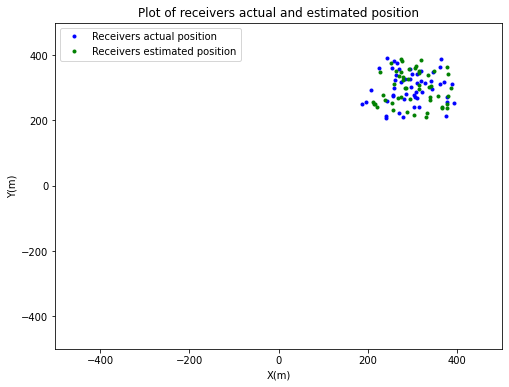

In [13]:
plt.figure(figsize=(8,6))
plt.plot(rec_pos_actual[:,0],rec_pos_actual[:,1],'b.',label='Receivers actual position')
#plt.plot(initial_pos[0,1:,0],initial_pos[0,1:,1],'k.',label='REceivers guessed position')
plt.plot(alpha_pos[1:,0],alpha_pos[1:,1],'g.',label='Receivers estimated position')


plt.legend()
plt.title('Plot of receivers actual and estimated position')
plt.xlim(-500,500)
plt.ylim(-500,500)
plt.xlabel('X(m)')
plt.ylabel('Y(m)')

Text(0, 0.5, 'Error (m^2)')

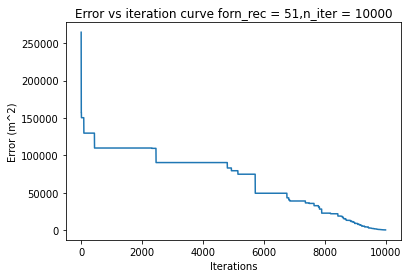

In [14]:
plt.plot(np.arange(start= 0,stop = n_iter,step =1), error_iter)
plt.title('Error vs iteration curve for'+'n_rec = '+str(n_rec)+',n_iter = '+ str(n_iter))
plt.xlabel('Iterations')
plt.ylabel('Error (m^2)')

An intersting observation is that due to the restriction imposed, there are not much improvements in the error. An intersting comparison could be made for the relative distance between receivers. When the error becomes zero it's the indication that the time difference of arrival between the estimated receivers and actual receivers has reached same value. 

Now, we'll note the effect of change of number of wolves and then comment further. Above comments are for 8 wolves, next we'll implement for 10 and 15 wolves and observe the results.

In [15]:
# Verification that the error atually gets to zero, we'll compare the TDOA actual and optimized for any two receivers
TDOA_optimised = np.sqrt((alpha_pos[2:,0] - alpha_pos[1,0])**2 + (alpha_pos[2:,1]-alpha_pos[1,1])**2)
TDOA_actual = t_Rec_real[1:] - t_Rec_real[0]

Text(0.5, 1.0, 'Comparing TDOA for verification')

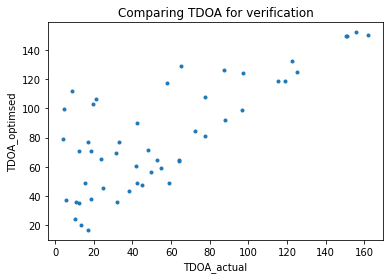

In [16]:
# Comparing the difference between 2 by plotting a line of points, if that line is y =x, we have the verification
plt.plot(abs(TDOA_actual),abs(TDOA_optimised),'.')
plt.xlabel('TDOA_actual')
plt.ylabel('TDOA_optimsed')
plt.title('Comparing TDOA for verification')

In [17]:
# checking the final alpha fitness value
print(alpha_fitness)

297.05241253898805


Since it's finite, some deviation are expected. Let's try to run for lesser receivers say 5 and then check. Clearly, it's not fitting for 5, trying for 2. That's kind of close,It is apparent here:

1. The sign of error has not been taken into consideration anywhere.

Plotting the abs values, we see that it fits well. Now trying the absolute plot for 51 receivers. Here, the deviations are quie signifcant in many cases. 